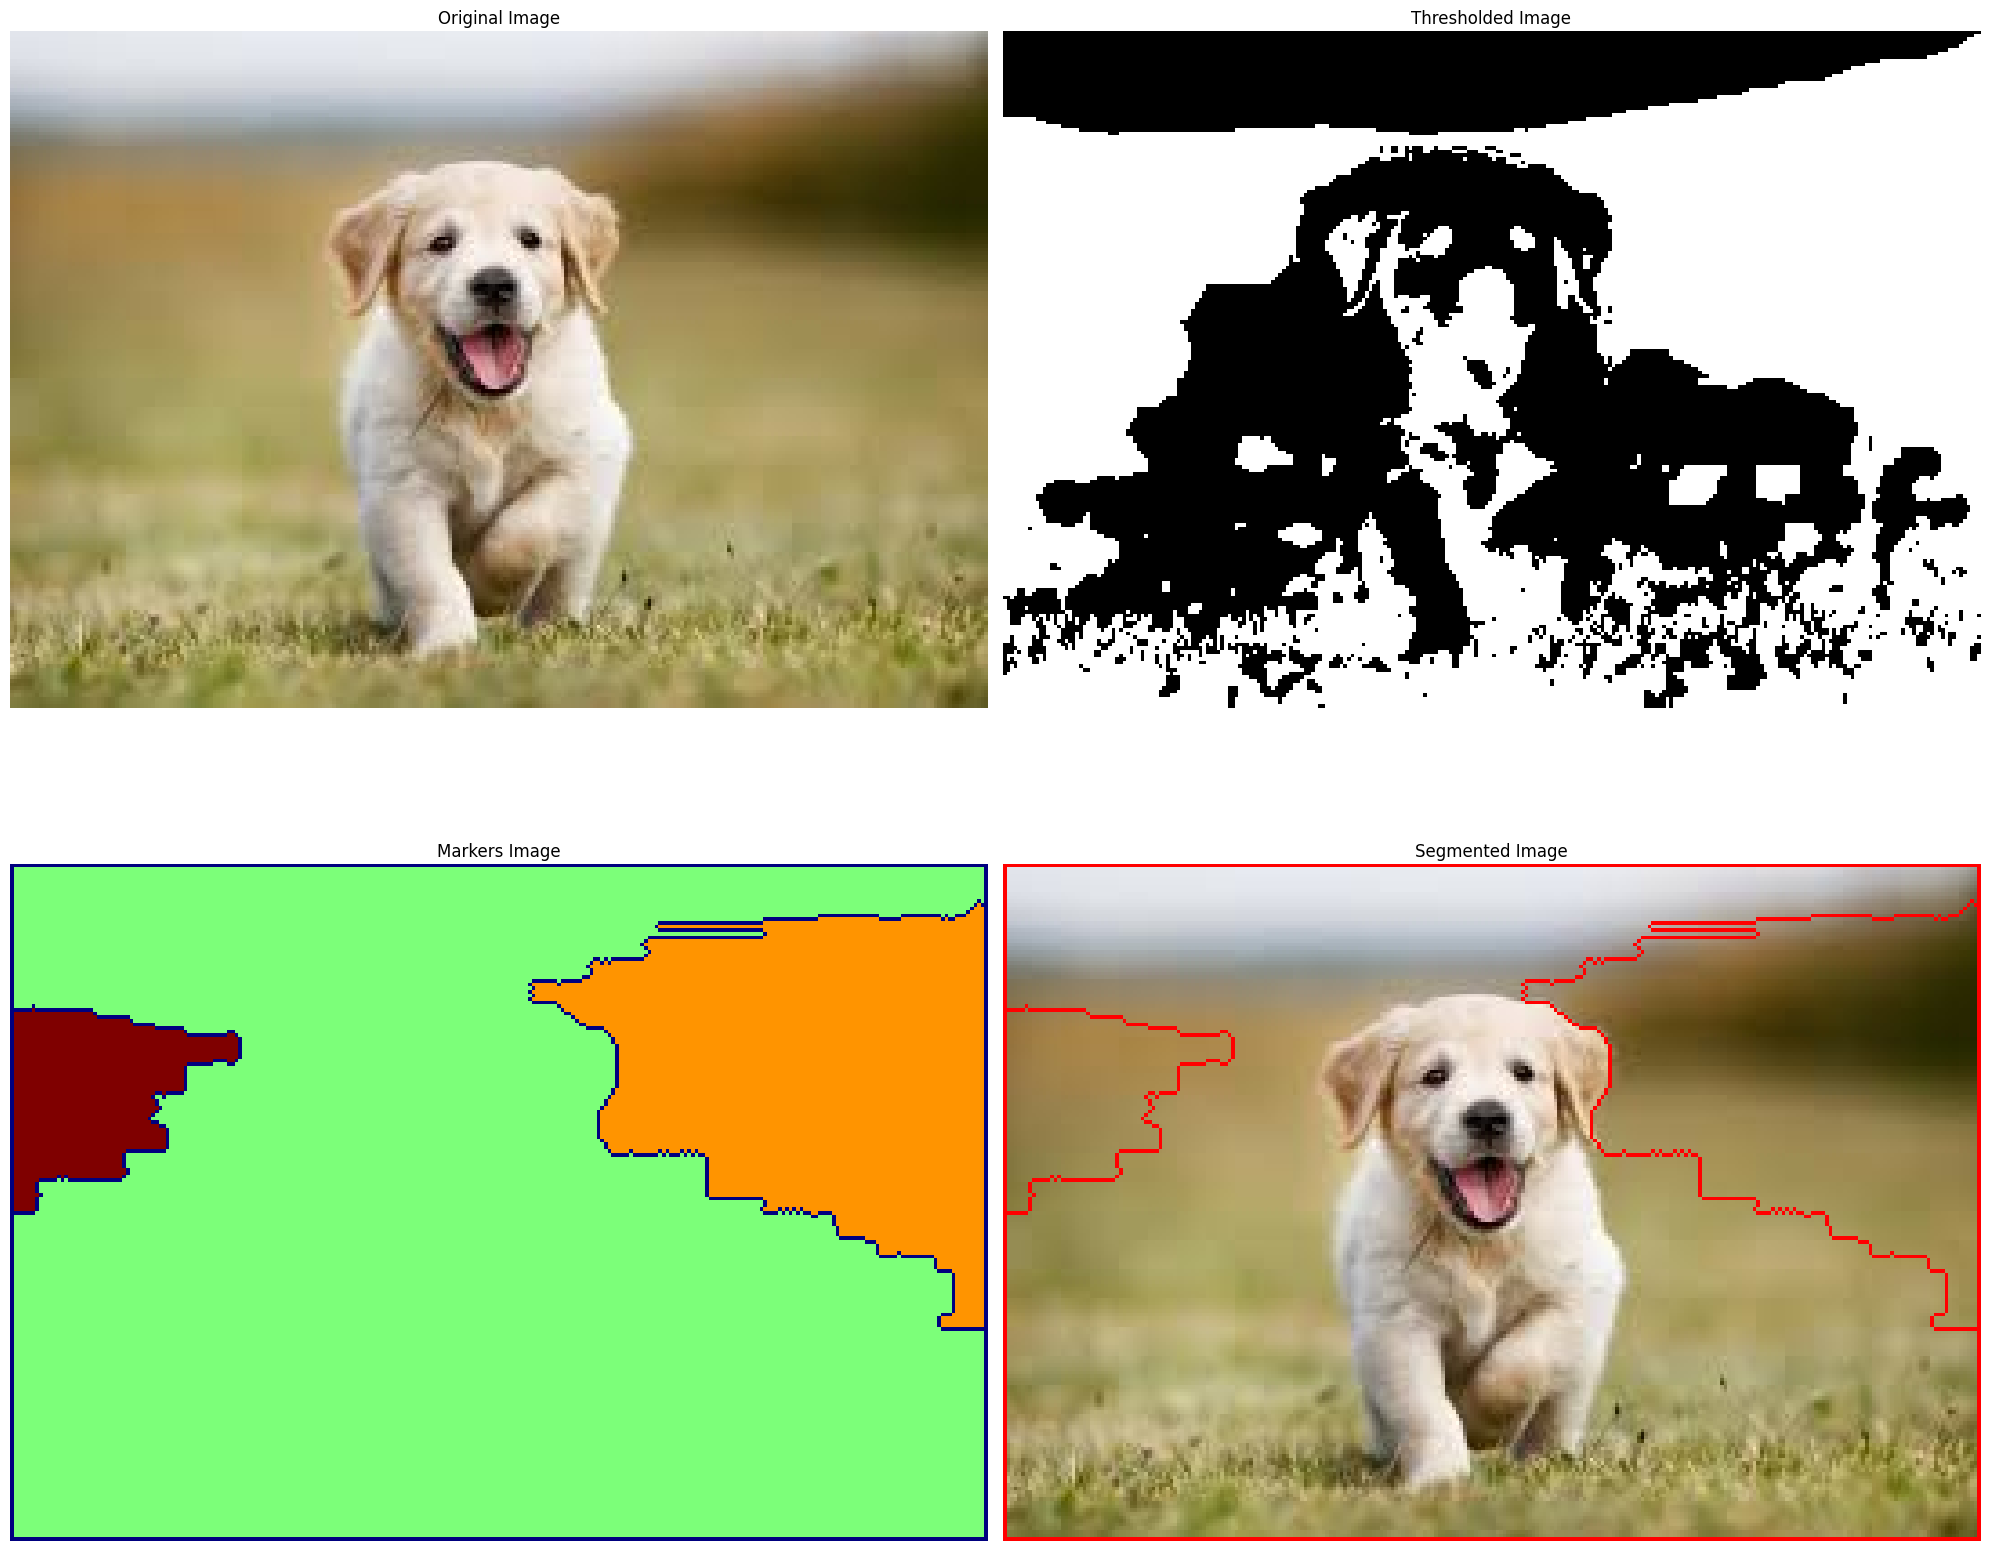

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utility to plot image
def plot_img(img, title=None, r=None, c=None, i=None, cmap=None):
    plt.subplot(r, c, i)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

# Load an Image
img = cv2.imread("puppy_dog.jpg")
assert img is not None, "Failed to load an image"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Save the original image before modification
img_original = img.copy()

# 1. Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 2. Apply Thresholding
ret, thresh = cv2.threshold(
    src=gray, 
    thresh=0,
    maxval=255,
    type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
)

# 3. Noise Removal
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 4. Sure Background Area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# 5. Finding Sure Foreground Area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# 6. Finding Unknown Region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# 7. Marker Labelling
ret, markers = cv2.connectedComponents(sure_fg)

# 8. Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# 9. Now, mark the region of unknown with zero
markers[unknown==255] = 0

# 10. Apply Watershed Algorithm
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

# Display the img to the screen
plt.figure(figsize=(20, 18))

plot_img(img_original, "Original Image", 2, 2, 1)
plot_img(thresh, "Thresholded Image", 2, 2, 2, cmap='gray')
plot_img(markers, "Markers Image", 2, 2, 3, cmap='jet')
plot_img(img, "Segmented Image", 2, 2, 4)

plt.tight_layout()
plt.show()